# GoPro Photos to Crop KMZ

<a target="_blank" href="https://colab.research.google.com/github/nasaharvest/street2sat/blob/gopro2crop/notebooks/GoPro2CropKMZ.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**Author**: Ivan Zvonkov

**Last Modified**: Jul 8, 2024

**Description**: Converts GoPro photos to crop type points. Specifically the notebook:

1. Downloads GoPro photos from street2sat bucket.
2. Create a dataframe from photos.
3. Extract dates and coordinates.
4. Classify as crop or not crop.
5. Segment crops in crop photos.
6. Filter out low confidence predictions.
7. Move coordinate to field
8. Get Admin Zones for each point
9. Create KMZ file
10. Save the notebook



## Important Prerequisite

Before running any cell in the notebook,
1. Click the drop down triangle on the top right hand side and select "Change Runtime Type".
2. Click the T4 radio button under Hardware Accelerator and click save.

This will allow the CropSegmentation model to run much faster.

In [1]:
# Required packages
!pip install exifread utm simplekml earthengine-api geemap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.6 MB/s eta 0:00:00


## 1. Download GoPro photos

In [2]:
# Login to Google Cloud, once you run this cell click on the space after "browser:" to enter the code
!gcloud auth login
# Your current project will be [None] and that is okay.

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=x4pxPphLSdcDKXpRXt2tjyKDoW9dB6&prompt=consent&token_usage=remote&access_type=offline&code_challenge=Jn9tqspUVf6yLhfUSvD3ZgWuEV--UBQMasxGvUwmi-E&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0ATx3LY4zRi1uzvWKPx2AAZ6EGWUEmNo3C2FA6ZPeUJAW5ZuM00ae6MTH5dlKNqE6D-KLGw

You are now logged in as [izvonkov@umd.edu].
Your current project is [N

In [4]:
from pathlib import Path

GCLOUD_BUCKET = "street2sat-uploaded"

# Specify the folder name and download the images
GCLOUD_FOLDER = "KENYA_v2/2022_07_13_Nakuru_2"

GCLOUD_PATH = f"gs://{GCLOUD_BUCKET}/{GCLOUD_FOLDER}/"
PREFIX = GCLOUD_FOLDER.replace("/", "_")
Path(PREFIX).mkdir(exist_ok=True)
print(f"Ready to download images from {GCLOUD_PATH} to {PREFIX}")

Ready to download images from gs://street2sat-uploaded/KENYA_v2/2022_07_13_Nakuru_2 to KENYA_v2_2022_07_13_Nakuru_2


In [ ]:
# Check amount of photos
!gsutil du $GCLOUD_PATH | wc -l

In [5]:
# 20 mins for 10k images
!gsutil -m cp -r $GCLOUD_PATH $PREFIX

Streaming output truncated to the last 5000 lines.
Copying gs://street2sat-uploaded/KENYA_v2/2022_07_13_Nakuru_2/G0128341.JPG...
Copying gs://street2sat-uploaded/KENYA_v2/2022_07_13_Nakuru_2/G0128342.JPG...
Copying gs://street2sat-uploaded/KENYA_v2/2022_07_13_Nakuru_2/G0128343.JPG...
Copying gs://street2sat-uploaded/KENYA_v2/2022_07_13_Nakuru_2/G0128344.JPG...
Copying gs://street2sat-uploaded/KENYA_v2/2022_07_13_Nakuru_2/G0128345.JPG...
Copying gs://street2sat-uploaded/KENYA_v2/2022_07_13_Nakuru_2/G0128346.JPG...
Copying gs://street2sat-uploaded/KENYA_v2/2022_07_13_Nakuru_2/G0128347.JPG...
Copying gs://street2sat-uploaded/KENYA_v2/2022_07_13_Nakuru_2/G0128348.JPG...
Copying gs://street2sat-uploaded/KENYA_v2/2022_07_13_Nakuru_2/G0128349.JPG...
Copying gs://street2sat-uploaded/KENYA_v2/2022_07_13_Nakuru_2/G0128350.JPG...
Copying gs://street2sat-uploaded/KENYA_v2/2022_07_13_Nakuru_2/G0128351.JPG...
Copying gs://street2sat-uploaded/KENYA_v2/2022_07_13_Nakuru_2/G0128353.JPG...
Copying gs://

## 2. Create dataframe from available photos

In [6]:
from datetime import datetime
from shapely.geometry import Point
from tqdm import tqdm

import exifread
import geopandas as gpd
import pandas as pd

tqdm.pandas()

In [7]:
image_folder = Path("/content/KENYA_v2_2022_07_13_Nakuru_2/2022_07_13_Nakuru_2")
if (not image_folder.exists()):
    print("STOP: Update image_folder to match the folder of images you downloaded")
else:
    gopro_photo_paths = list(image_folder.glob("*.JPG")) # May need to switch to .jpg
    df = pd.DataFrame({"paths": gopro_photo_paths})

In [8]:
df

,paths
0,/content/KENYA_v2_2022_07_13_Nakuru_2/2022_07_...
1,/content/KENYA_v2_2022_07_13_Nakuru_2/2022_07_...
2,/content/KENYA_v2_2022_07_13_Nakuru_2/2022_07_...
3,/content/KENYA_v2_2022_07_13_Nakuru_2/2022_07_...
4,/content/KENYA_v2_2022_07_13_Nakuru_2/2022_07_...
...,...
10306,/content/KENYA_v2_2022_07_13_Nakuru_2/2022_07_...
10307,/content/KENYA_v2_2022_07_13_Nakuru_2/2022_07_...
10308,/content/KENYA_v2_2022_07_13_Nakuru_2/2022_07_...
10309,/content/KENYA_v2_2022_07_13_Nakuru_2/2022_07_...


## 3. Extract date and coordinate from each available photo

In [9]:
def extract_date_lat_lon(img_path):
    img_bytes = open(img_path, "rb")
    tags = exifread.process_file(img_bytes)
    if tags == {}:
        print("No exiftags found")
        return None, None, None

    # Extract date
    image_datetime = str(tags.get("Image DateTime"))

    # Convert to Python datetime object
    dt = datetime.strptime(image_datetime, "%Y:%m:%d %H:%M:%S")

    def convert_to_degrees(coord):
        """ Convert the GPS coordinates stored in the EXIF to degress in float format"""
        d = float(coord.values[0].num) / float(coord.values[0].den)
        m = float(coord.values[1].num) / float(coord.values[1].den)
        s = float(coord.values[2].num) / float(coord.values[2].den)
        return d + (m / 60.0) + (s / 3600.0)

    lat = convert_to_degrees(tags.get("GPS GPSLatitude"))
    lon = convert_to_degrees(tags.get("GPS GPSLongitude"))

    if tags.get("GPS GPSLatitudeRef").values[0] != "N":
        lat = 0 - lat
    if tags.get("GPS GPSLongitudeRef").values[0] != "E":
        lon = 0 - lon

    return dt, lat, lon

# Extract date and lat lon from each image
df[["date", "lat", "lon"]] = df["paths"].progress_apply(extract_date_lat_lon).to_list()

100%|██████████| 10311/10311 [01:07<00:00, 151.92it/s]


In [10]:
df

,paths,date,lat,lon
0,/content/KENYA_v2_2022_07_13_Nakuru_2/2022_07_...,2022-07-13 11:25:28,-0.516932,36.045497
1,/content/KENYA_v2_2022_07_13_Nakuru_2/2022_07_...,2022-07-14 12:30:10,-0.431352,35.938142
2,/content/KENYA_v2_2022_07_13_Nakuru_2/2022_07_...,2022-07-14 11:10:02,-0.453002,36.028163
3,/content/KENYA_v2_2022_07_13_Nakuru_2/2022_07_...,2022-07-13 11:19:53,-0.48906,36.038898
4,/content/KENYA_v2_2022_07_13_Nakuru_2/2022_07_...,2022-07-13 11:06:28,-0.451747,36.017777
...,...,...,...,...
10306,/content/KENYA_v2_2022_07_13_Nakuru_2/2022_07_...,2022-07-14 12:11:37,-0.514272,35.962148
10307,/content/KENYA_v2_2022_07_13_Nakuru_2/2022_07_...,2022-07-14 12:24:31,-0.455549,35.95057
10308,/content/KENYA_v2_2022_07_13_Nakuru_2/2022_07_...,2022-07-13 10:57:04,-0.421193,36.032356
10309,/content/KENYA_v2_2022_07_13_Nakuru_2/2022_07_...,2022-07-13 11:13:40,-0.459017,36.022295


In [11]:
gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df["lon"], df["lat"])])

<ipython-input-12-e0163e7764ca>:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


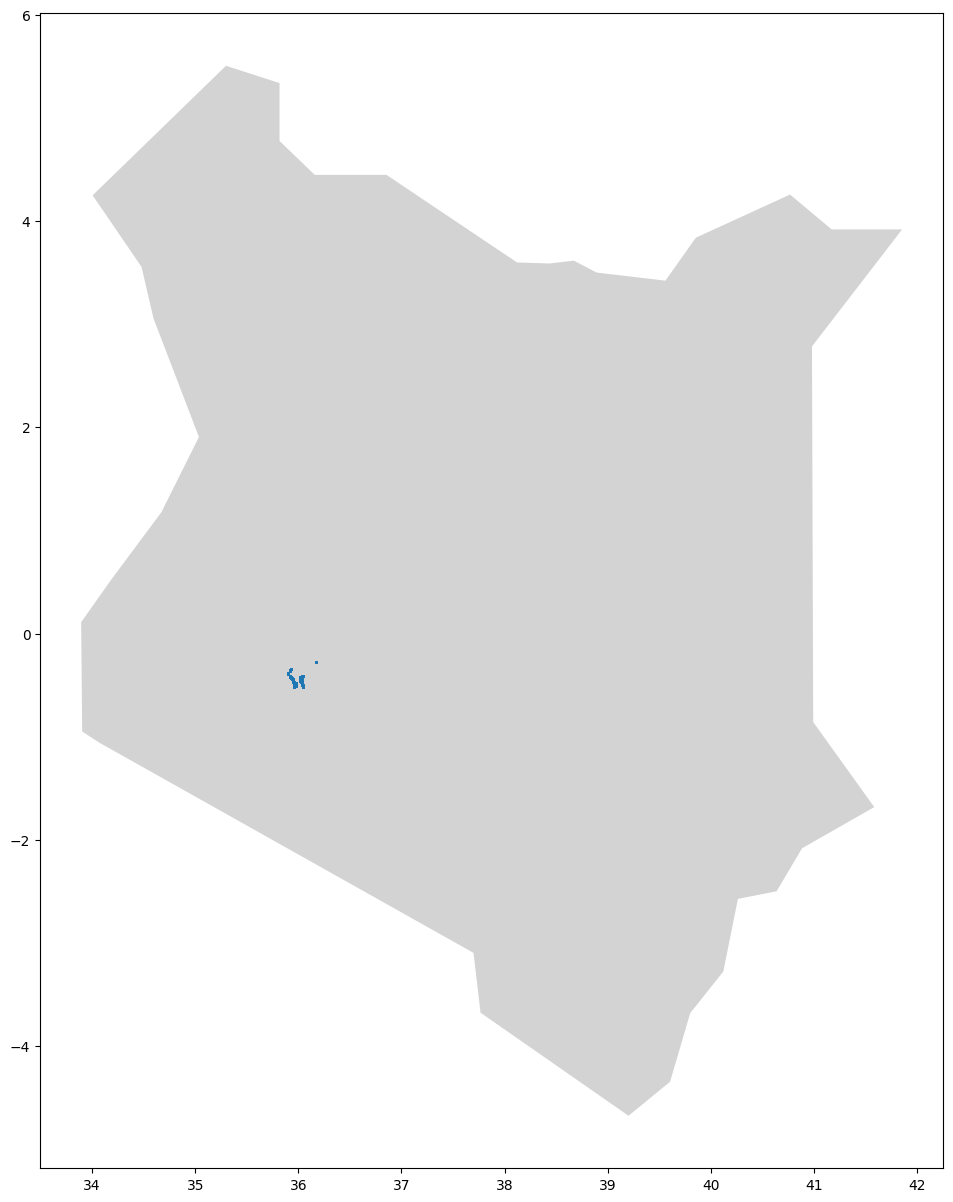

In [12]:
# TODO better point plotting

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
region = world[world["name"] == "Kenya"]
ax = region.plot(facecolor="lightgray", figsize=(15, 15));

gdf.plot(
    ax=ax,
    marker='o',
    categorical=True,
    markersize=1,
    #column=DATASET,
    legend=True,
    legend_kwds={'loc': 'lower left'});

## 4. Classify as crop or not crop

In [13]:
# Download CropNop model weights
!gsutil cp gs://street2sat-models/cropnop_v1.torchscript.pt .

Copying gs://street2sat-models/cropnop_v1.torchscript.pt...
- [1 files][  3.4 MiB/  3.4 MiB]                                                
Operation completed over 1 objects/3.4 MiB.                                      


In [14]:
import cv2
import matplotlib.pyplot as plt
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CropNop model
cropnop_model = torch.jit.load("/content/cropnop_v1.torchscript.pt")

def is_crop_or_not(img_path):

    # Preprocess image
    img = plt.imread(img_path)
    img = cv2.resize(img, (300, 300)) / 255
    img = img.transpose(2, 0, 1).astype("float32")
    img_tensor = torch.from_numpy(img).float().to(device)

    # Make crop or not prediction
    output = cropnop_model(img_tensor.unsqueeze(0))
    is_crop = (output <= 0).item()
    return is_crop

CropNop Model Prediction: Not crop


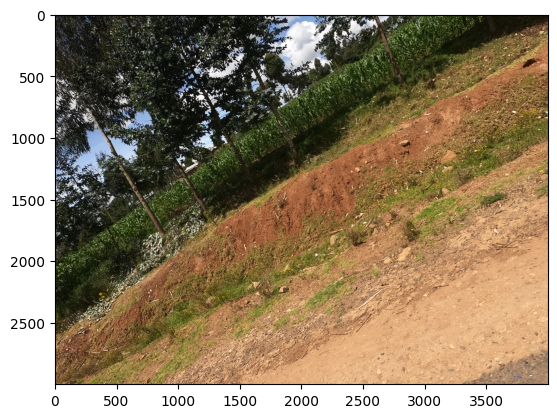

In [15]:
# CropNop Example
img_path = df["paths"].loc[8]
is_crop_prediction = is_crop_or_not(img_path)

plt.imshow(plt.imread(img_path))
print(f"CropNop Model Prediction: {'Crop' if is_crop_prediction else 'Not crop'}")

In [16]:
# 20 mins for 10k images
df["is_crop"] = df["paths"].progress_apply(is_crop_or_not)

100%|██████████| 10311/10311 [28:13<00:00,  6.09it/s]


In [17]:
df["is_crop"].value_counts()

is_crop
False    8256
True     2055
Name: count, dtype: int64

## 5. Segment crops

In [18]:
# Download CropSeg model weights
!gsutil cp gs://street2sat-models/cropseg_v1.torchscript.pt .

Copying gs://street2sat-models/cropseg_v1.torchscript.pt...
/ [1 files][130.7 MiB/130.7 MiB]                                                
Operation completed over 1 objects/130.7 MiB.                                    


In [19]:
from skimage.io import imread
from skimage.transform import resize

import numpy as np
import os

os.environ["LRU_CACHE_CAPACITY"] = "1"

# Load CropSeg model
cropseg_model = torch.jit.load("/content/cropseg_v1.torchscript.pt")

CLASSES = [
    "background",
    "banana",
    "maize",
    "rice",
    "soybean",
    "sugarcane",
    "sunflower",
    "tobacco",
    "wheat",
]

def segment_crops(img_path):
    img = imread(img_path)
    img = resize(img, (800, 800))
    img = img.astype(float)
    img = (
        255 * (img - np.min(img[:])) / (np.max(img[:]) - np.min(img[:]) + 0.1)
    ).astype(float)
    img = (img + 0.5) / 256
    gamma = -1 / np.nanmean(np.log(img))
    img = img ** (gamma)
    img_transposed = img.transpose(2, 0, 1).astype("float32")
    img_tensor = torch.from_numpy(img_transposed).unsqueeze(0).to(device)
    return img, cropseg_model(img_tensor)[0].cpu().detach().numpy()


def segment_crops_w_proportions(img_path):
    _, output = segment_crops(img_path)
    image_size = output.shape[1] * output.shape[2]
    segmentation_proportions = {
        crop:  round(output[i].sum() / image_size, 4) for i, crop in enumerate(CLASSES)
    }
    return segmentation_proportions

In [20]:
df_crops = df[df['is_crop']].copy()

maize: 0.0263
tobacco: 0.0001


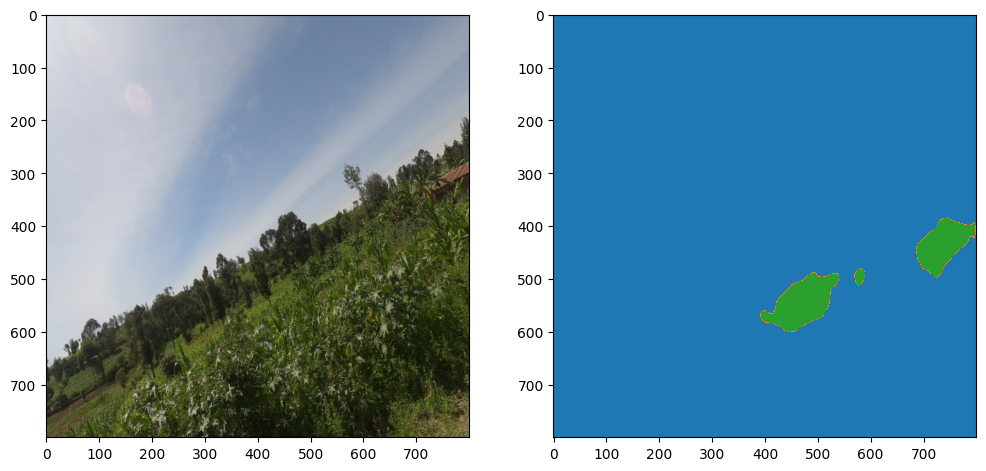

In [22]:
# Example CropSeg Predictions
img_path = df_crops["paths"].iloc[0]
img, output = segment_crops(img_path)
props = segment_crops_w_proportions(img_path)

fig, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].imshow(img)
axes[1].imshow(output.argmax(axis=0), cmap='tab10', vmin=0, vmax=len(CLASSES))
for crop, prop in sorted(props.items(), key=lambda item: item[1], reverse=True):
    if crop != "background" and prop > 0:
        print(f"{crop}: {prop}")

In [23]:
# ~10 mins for 500 images, 1hr for 2k images
# TODO can probably make predictions faster through batches
df_crops["segmentation_proportions"] = df_crops["paths"].progress_apply(segment_crops_w_proportions)

100%|██████████| 2055/2055 [1:07:21<00:00,  1.97s/it]


In [24]:
proportion_columns = pd.json_normalize(df_crops["segmentation_proportions"]).set_index(df_crops.index)
df_crop_prop = pd.concat([df_crops, proportion_columns], axis=1)

In [25]:
crops = list(proportion_columns.columns[1:][1:])
if "dominant_crop" not in df_crop_prop.columns:
    df_crop_prop["dominant_crop"] = df_crop_prop[crops].apply(lambda x: max(dict(x), key=dict(x).get), axis=1)

## 6. Filter out low confidence predictions

In [26]:
print(f"Before background filter: {len(df_crop_prop)}")

# Only points with less than 95% background kept
bg_threshold = 0.95
df_crops_filtered = df_crop_prop[df_crop_prop["background"] < bg_threshold ].copy()
print(f"After background filter: {len(df_crops_filtered)}")


Before background filter: 2055
After background filter: 1092


## 7. Move coordinate to field

In [27]:
import utm
from datetime import timedelta
import math

# TODO add visual example

In [28]:
# Copied and pasted from field_coord_distance_offset.ipynb

floor10 = lambda x: x//10 * 10
to_pixel_centroid = lambda coord: (floor10(coord[0]) + 5, floor10(coord[1]) + 5)

def generate_offset_point_wgs84(coord0, coord1, is_right_hand_drive=True, meters=20):
    utm_coord0 = utm.from_latlon(coord0[0], coord0[1])
    utm_coord1 = utm.from_latlon(coord1[0], coord1[1])

    for i, zone_type in [(2, "number"), (3, "letter")]:
        if utm_coord1[i] != utm_coord0[i]:
            print(utm_coord0)
            print(utm_coord1)
            raise ValueError(f"UTM Zone {zone_type} mismatch: {utm_coord0[i]} and {utm_coord1[i]}")


    delta_east = utm_coord1[0] - utm_coord0[0]
    delta_north = utm_coord1[1] - utm_coord0[1]

    # Offset for meters change in offset point distance
    x_offset = np.abs(meters * math.cos(math.atan(delta_east / delta_north)))

    # Direction of offset
    x_direction = np.sign(delta_north) if is_right_hand_drive else -np.sign(delta_north)
    x_offset *= x_direction

    orthogonal_slope = -delta_east / delta_north
    orthogonal_b = utm_coord1[1] - (orthogonal_slope * utm_coord1[0])
    orthogonal_y = lambda x: orthogonal_slope*x + orthogonal_b

    field_point_x = utm_coord1[0] + x_offset
    field_point_y = orthogonal_y(field_point_x)

    field_latlon = utm.to_latlon(field_point_x, field_point_y, utm_coord1[2], utm_coord1[3])

    pixel_centroid_x, pixel_centroid_y  = to_pixel_centroid((field_point_x, field_point_y))
    pixel_centroid_field_latlon = utm.to_latlon(pixel_centroid_x, pixel_centroid_y, utm_coord1[2], utm_coord1[3])

    return field_latlon, pixel_centroid_field_latlon, (delta_east, delta_north)

def road_pixel_centroid(coord):
    utm_coord = utm.from_latlon(coord[0], coord[1])
    utm_pixel_centroid = to_pixel_centroid(utm_coord)
    return utm.to_latlon(*utm_pixel_centroid, utm_coord[2], utm_coord[3])

In [30]:
field_points = []
is_right_hand_drive = False

for i in tqdm(range(0, len(df_crops_filtered))):

    # Get road coordinate
    current_record = df_crops_filtered.iloc[i]
    road_coord = current_record["lat"], current_record["lon"]
    road_10m_centroid = road_pixel_centroid(road_coord)

    # Get prior coordinate
    time1 = current_record["date"]
    before_time_interval = time1 - timedelta(seconds=10)
    time_filter = (df["date"] < str(time1)) & (df["date"] > str(before_time_interval))
    prior_records = df[time_filter].sort_values(by=['date'])
    if len(prior_records) == 0:
        print(f"No prior records found for {i}")
        continue

    prior_record = prior_records.iloc[-1]
    prior_coord = prior_record["lat"], prior_record["lon"]

    # Get direction and field offset
    try:
        output = generate_offset_point_wgs84(prior_coord, road_coord, is_right_hand_drive)
        offset_field_coord, offset_field_pixel_centroid, driving_direction = output

        field_points.append({
            "road_pixel_centroid": road_10m_centroid,
            "is_right_hand_drive": is_right_hand_drive,
            "driving_easting": driving_direction[0],
            "driving_northing": driving_direction[1],
            "offset_field_coord": offset_field_coord,
            "offset_field_pixel_centroid": offset_field_pixel_centroid,
            "time_computed": datetime.now(),
            **df_crops_filtered.iloc[i],
        })
    except Exception as e:
        print(f"Index: {i}, Exception: {e}")


 33%|███▎      | 360/1092 [00:00<00:01, 442.68it/s]<ipython-input-28-f9cc463eaf0b>:21: RuntimeWarning: invalid value encountered in scalar divide
  x_offset = np.abs(meters * math.cos(math.atan(delta_east / delta_north)))
<ipython-input-28-f9cc463eaf0b>:27: RuntimeWarning: invalid value encountered in scalar divide
  orthogonal_slope = -delta_east / delta_north
 41%|████      | 448/1092 [00:01<00:01, 424.29it/s]

Index: 365, Exception: easting out of range (must be between 100,000 m and 999,999 m)


 53%|█████▎    | 581/1092 [00:01<00:01, 433.75it/s]

No prior records found for 524
Index: 578, Exception: easting out of range (must be between 100,000 m and 999,999 m)


 69%|██████▉   | 756/1092 [00:01<00:00, 422.19it/s]

No prior records found for 677
No prior records found for 722


100%|██████████| 1092/1092 [00:02<00:00, 429.01it/s]


In [31]:
df_crop_type_w_duplicates = pd.DataFrame(field_points)
print(f"Points BEFORE deduplicating: {len(df_crop_type_w_duplicates)}")

Points BEFORE deduplicating: 1087


In [32]:
# Deduplication by selecting max dominant crop
def get_max_dominant_crop(group):
  max_idx = group.apply(lambda x: x[x['dominant_crop']], axis=1).idxmax()
  return group.loc[max_idx]

# create new DataFrame with no duplicate - using groupby and applying get_max_dominant_crop on each group
df_crop_type = df_crop_type_w_duplicates.groupby('offset_field_pixel_centroid').apply(get_max_dominant_crop).reset_index(drop=True)
print(f"Points AFTER deduplicating: {len(df_crop_type)}")

Points AFTER deduplicating: 635


## 8. Get Admin Zones for each point

In [33]:
# Obtain Admin Boundaries from GADM: https://gadm.org/data.html
gdf_gadm2 = gpd.read_file("https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_KEN_2.json")

In [34]:
geometry = [Point(xy) for xy in zip(df_crop_type["lon"], df_crop_type["lat"])]
gdf_points = gpd.GeoDataFrame(df_crop_type, geometry=geometry, crs="EPSG:4326")
gdf_points_gadm2 = gpd.sjoin(gdf_points, gdf_gadm2, how='left', op='within')

df_crop_type["GADM1"] = gdf_points_gadm2["NAME_1"]
df_crop_type["GADM2"] = gdf_points_gadm2["NAME_2"]

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [35]:
df_crop_type["GADM1"].value_counts()

GADM1
Nakuru    635
Name: count, dtype: int64

In [36]:
df_crop_type["GADM2"].value_counts()

GADM2
Njoro    635
Name: count, dtype: int64

## 9. Create KMZ file

In [37]:
import simplekml

DATA_GADM1_ZONES =  "_".join(df_crop_type["GADM1"].unique())
if DATA_GADM1_ZONES not in PREFIX:
    PREFIX += f"_{DATA_GADM1_ZONES}"

DATA_YEARS = "_".join([str(year) for year in df_crop_type["date"].dt.year.unique()])
if DATA_YEARS not in PREFIX:
    PREFIX += f"_{DATA_YEARS}"

DATA_BG_THRESHOLD = f"bg{int(bg_threshold*100)}"
PREFIX += f"_{DATA_BG_THRESHOLD}"

# Change if necessary
PREFIX

'KENYA_v2_2022_07_13_Nakuru_2_bg95'

In [38]:
endpoint_prefix = GCLOUD_PATH.replace("gs://", "")


def create_description(record, image_path):
    image_name = Path(image_path).name
    endpoint = Path(endpoint_prefix + "/" + image_name)
    name = "-".join(endpoint.parts[2:-1]) + "-" + endpoint.stem
    return f"""
<img src='files/{image_name}' width='900px'/>
<br/>
<h2>{name}</h2>
<p>Capture Time: {record['date']}</p>
<a href='https://storage.cloud.google.com/{endpoint}'>
    https://storage.cloud.google.com/{endpoint}
</a>

<h2>Location</h2>
<p>GADM1: {record['GADM1']}</p>
<p>GADM2: {record['GADM2']}</p>
<p>Road Lat Lon: {record['lat']}, {record['lon']}</p>
<p>Field Lat Lon:  {record["offset_field_pixel_centroid"]}</p>


<h2>Driving Direction</h2>
<p>Northing: {record['driving_northing']}</p>
<p>Easting: {record['driving_easting']}</p>
<p>Is Right Hand Drive: {record['is_right_hand_drive']}</p>

<h2>CropSeg Model Prediction</h2>
<p>{record['segmentation_proportions']}</p>

"""

In [39]:
# Create KMZ file for every 100 points (more points make the KMZ laggy)
num_records = len(df_crop_type)

for range_start in range(0, num_records, 100):
    if range_start + 100 < num_records:
        range_end = range_start + 100
    else:
        range_end = num_records

    kml_document_name = PREFIX + f"_{range_start}_{range_end}"

    kml = simplekml.Kml()
    kml.document.name = kml_document_name

    for _, record in tqdm(df_crop_type[range_start:range_end].iterrows()):
        latlon = record["offset_field_pixel_centroid"]
        image_path = record['paths']
        kml.newpoint(
            coords=[(latlon[1], latlon[0])],  # lon, lat optional height
            description=create_description(record, image_path),
            name=record["dominant_crop"],
            timestamp=record["date"]
        )
        kml.addfile(image_path)


    kml.savekmz(f"{kml_document_name}.kmz", format=False)

100it [00:00, 2760.83it/s]
100it [00:00, 4227.66it/s]
100it [00:00, 4550.96it/s]
100it [00:00, 2242.19it/s]
100it [00:00, 4434.85it/s]
100it [00:00, 4312.33it/s]
35it [00:00, 1894.08it/s]


In [40]:
# Upload KMZ files to my Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

!cp -r /content/*.kmz /content/gdrive/My\ Drive


Mounted at /content/gdrive


The uploaded KMZ files can now be downloaded onto a computer with Google Earth Pro.

A Quality Assessment must be conducted following this protocol:

https://docs.google.com/document/d/1OCF2gpCQQbZP-y6xcTbKE2OzhkxMtyaJi8wiWi8jfzs/edit?usp=sharing

## 10. Save the notebook

1. Click File / Download / Download .ipynb
2. Rename this notebook to have the name: ` <PREFIX>.ipynb`


In [41]:
print(f"Suggested notebook name: {PREFIX}.ipynb")

Suggested notebook name: KENYA_v2_2022_07_13_Nakuru_2_bg95.ipynb
